In [ ]:
import pandas as pd

file_path = "../data/raw/statcan_quarterly_rent_vancouver.csv"

df_raw = pd.read_csv(
    file_path,
    header=8
)

df_raw.head()


In [ ]:
from pathlib import Path

path = Path("../data/raw/statcan_quarterly_rent_vancouver.csv")

with path.open(encoding="utf-8", errors="replace") as f:
    for i in range(15):
        print(f"{i:02d}: {f.readline().rstrip()}")


In [ ]:
df_raw.columns


In [ ]:
df_clean = df_raw[
    df_raw["Geography"] == "Vancouver, Census metropolitan area (CMA)"
].copy()

df_clean.shape


In [ ]:
df_clean["Geography"].unique()


In [ ]:
df_clean = df_clean.dropna(subset=["Rental unit type"]).copy()
df_clean["Rental unit type"].value_counts()


In [ ]:
df_raw["Geography"] == "Vancouver, Census metropolitan area (CMA)"


In [ ]:
df_raw["Geography"] = df_raw["Geography"].ffill()


In [ ]:
df_clean = df_raw[
    df_raw["Geography"] == "Vancouver, Census metropolitan area (CMA)"
].copy()

df_clean.shape


In [ ]:
df_clean = df_clean.dropna(subset=["Rental unit type"]).copy()
df_clean["Rental unit type"].value_counts()


In [ ]:
df_long = df_clean.melt(
    id_vars=["Geography", "Rental unit type"],
    var_name="quarter",
    value_name="avg_rent"
)

df_long.head(10)


In [ ]:
df_long["Rental unit type"].value_counts()


In [ ]:
df_long.head()
df_long["Rental unit type"].value_counts()


In [ ]:
df_long = df_clean.melt(
    id_vars=["Geography", "Rental unit type"],
    var_name="quarter",
    value_name="avg_rent"
)

df_long.head(20)


In [ ]:
for col in df_clean.columns:
    print(repr(col))


In [ ]:
df_clean.columns = (
    df_clean.columns
    .str.strip()            # remove leading/trailing spaces
    .str.replace("\n", " ", regex=False)
    .str.replace("\xa0", " ", regex=False)  # StatCan non-breaking space
)


In [ ]:
df_clean.columns


In [ ]:
df_long = df_clean.melt(
    id_vars=["Geography", "Rental unit type"],
    var_name="quarter",
    value_name="avg_rent"
)

df_long["quarter"].unique()


In [ ]:
df_long["quarter"].unique()


In [ ]:
# remove commas, convert to numeric
df_long["avg_rent"] = (
    df_long["avg_rent"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)

df_long["avg_rent"] = pd.to_numeric(df_long["avg_rent"], errors="coerce")

df_long["avg_rent"].describe()


In [ ]:
df_long["quarter"] = df_long["quarter"].str.replace(" ", "")
df_long["quarter"] = pd.PeriodIndex(df_long["quarter"], freq="Q").to_timestamp()

df_long[["quarter"]].drop_duplicates().head()


In [24]:
# Make quarter strings parseable: "Q1 2019" -> "2019Q1"
q = df_long["quarter"].astype(str).str.strip()
df_long["quarter"] = (q.str.extract(r"Q([1-4])\s*([0-9]{4})")
                        .apply(lambda x: f"{x[1]}Q{x[0]}", axis=1))

# Convert to timestamp (end of quarter)
df_long["quarter"] = pd.PeriodIndex(df_long["quarter"], freq="Q").to_timestamp(how="end")

df_long["quarter"].drop_duplicates().sort_values().head()


0    2019-03-31 23:59:59.999999999
5    2019-06-30 23:59:59.999999999
10   2019-09-30 23:59:59.999999999
15   2019-12-31 23:59:59.999999999
20   2020-03-31 23:59:59.999999999
Name: quarter, dtype: datetime64[ns]

In [25]:
df_long["quarter"].min(), df_long["quarter"].max()


(Timestamp('2019-03-31 23:59:59.999999999'),
 Timestamp('2025-09-30 23:59:59.999999999'))

In [26]:
df_gold = df_long.rename(columns={
    "Geography": "geography",
    "Rental unit type": "rental_unit_type"
})[
    ["quarter", "geography", "rental_unit_type", "avg_rent"]
]

df_gold.head(10)
df_gold.shape


(135, 4)

In [27]:
df_gold["rental_unit_type"].value_counts()


rental_unit_type
Apartment - No bedroom            27
Apartment - 1 bedroom             27
Apartment - 2 bedrooms            27
Apartment - 3 or more bedrooms    27
Room                              27
Name: count, dtype: int64

In [28]:
df_gold["quarter"].min(), df_gold["quarter"].max()


(Timestamp('2019-03-31 23:59:59.999999999'),
 Timestamp('2025-09-30 23:59:59.999999999'))

In [29]:
df_gold.isna().sum()


quarter             0
geography           0
rental_unit_type    0
avg_rent            9
dtype: int64

In [30]:
df_gold.to_csv(
    "../data/processed/vancouver_quarterly_rent_gold.csv",
    index=False
)


In [31]:
df_gold.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   quarter           135 non-null    datetime64[ns]
 1   geography         135 non-null    object        
 2   rental_unit_type  135 non-null    object        
 3   avg_rent          126 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.3+ KB


In [32]:
df_gold.duplicated(
    subset=["quarter", "geography", "rental_unit_type"]
).sum()


np.int64(0)

In [33]:
df_gold["rental_unit_type"].value_counts()


rental_unit_type
Apartment - No bedroom            27
Apartment - 1 bedroom             27
Apartment - 2 bedrooms            27
Apartment - 3 or more bedrooms    27
Room                              27
Name: count, dtype: int64

In [34]:
df_gold["quarter"].min(), df_gold["quarter"].max()


(Timestamp('2019-03-31 23:59:59.999999999'),
 Timestamp('2025-09-30 23:59:59.999999999'))

In [35]:
df_gold["avg_rent"].describe()


count     126.000000
mean     2376.428571
std      1087.680442
min       750.000000
25%      1655.000000
50%      2255.000000
75%      3185.000000
max      4950.000000
Name: avg_rent, dtype: float64

In [36]:
import matplotlib.pyplot as plt

sample = df_gold[df_gold["rental_unit_type"] == "Apartment - 1 bedroom"]

plt.plot(sample["quarter"], sample["avg_rent"])
plt.title("Vancouver 1-Bedroom Rent Trend")
plt.xlabel("Quarter")
plt.ylabel("Average Rent")
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

In [1]:
import matplotlib.pyplot as plt

sample = df_gold[df_gold["rental_unit_type"] == "Apartment - 1 bedroom"]

plt.figure()
plt.plot(sample["quarter"], sample["avg_rent"])
plt.title("Vancouver 1-Bedroom Rent Trend")
plt.xlabel("Quarter")
plt.ylabel("Average Rent ($)")
plt.show()


NameError: name 'df_gold' is not defined

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_gold = pd.read_csv(
    "../data/processed/vancouver_quarterly_rent_gold.csv",
    parse_dates=["quarter"]
)


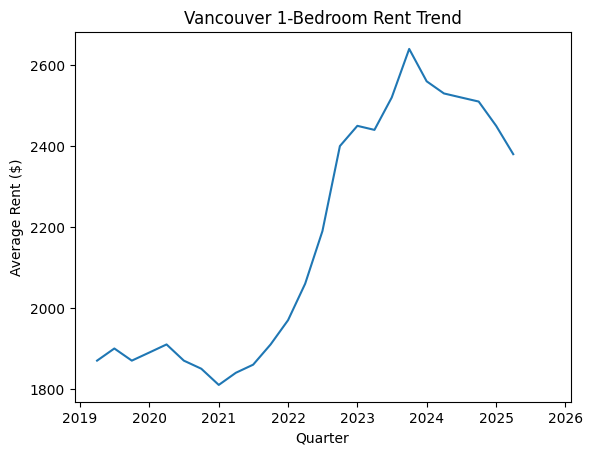

In [4]:
sample = df_gold[df_gold["rental_unit_type"] == "Apartment - 1 bedroom"]

plt.figure()
plt.plot(sample["quarter"], sample["avg_rent"])
plt.title("Vancouver 1-Bedroom Rent Trend")
plt.xlabel("Quarter")
plt.ylabel("Average Rent ($)")
plt.show()


In [5]:
df_gold.to_csv("../data/processed/vancouver_quarterly_rent_gold.csv", index=False)


In [6]:
import pandas as pd

df_gold = pd.read_csv(
    "../data/processed/vancouver_quarterly_rent_gold.csv",
    parse_dates=["quarter"]
)

df_gold.head()


,quarter,geography,rental_unit_type,avg_rent
0,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,1730.0
1,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,1870.0
2,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,2490.0
3,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,3480.0
4,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Room,770.0


In [7]:
df_gold


,quarter,geography,rental_unit_type,avg_rent
0,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,1730.0
1,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,1870.0
2,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,2490.0
3,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,3480.0
4,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Room,770.0
...,...,...,...,...
130,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,2100.0
131,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,2390.0
132,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,3190.0
133,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,4340.0


In [8]:
df_gold_sorted = df_gold.sort_values(
    ["quarter", "rental_unit_type"]
).reset_index(drop=True)

df_gold_sorted


,quarter,geography,rental_unit_type,avg_rent
0,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,1870.0
1,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,2490.0
2,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,3480.0
3,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,1730.0
4,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Room,770.0
...,...,...,...,...
130,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,2390.0
131,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,3190.0
132,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,4340.0
133,2025-09-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,2100.0


In [9]:
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

df_gold


,quarter,geography,rental_unit_type,avg_rent
0,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,1730.0
1,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,1870.0
2,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,2490.0
3,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,3480.0
4,2019-03-31 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Room,770.0
5,2019-06-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - No bedroom,1680.0
6,2019-06-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 1 bedroom,1900.0
7,2019-06-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 2 bedrooms,2580.0
8,2019-06-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Apartment - 3 or more bedrooms,3670.0
9,2019-06-30 23:59:59.999999999,"Vancouver, Census metropolitan area (CMA)",Room,770.0


In [10]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
